# Lab exercise 06, SVM


---



1, Load, preprocess and explore the data
* A, Download the NBA Matches 2013-2018 dataset from Kaggle: https://www.kaggle.com/mariodrusso/nba-matches-2013-18
* B, Each game appears twice in the database. Both time the match is marked from the view of the given team. Keep only those matches, where the match is marked from the viewpoint of the home team! (You may need to check and understand the column names.)
* C, Convert the 'Result' column to binary, which marks if the home team won (1) or lost (0). 
* D, Create two datasets, one with all the matches that were played in 2015 and one with all the matches that were played in 2016.
* E, Keep only the following columns for both:  
['Result', '2-Point Field Goals', '2-point Field Goal Attempts', '3-Point Field Goals', '3-Point Field Goal Attempts', 'Free Throws', 'Free Throw Attempts']

2, Data exploration - **you need to complete this task only for the 2015 data**
* A, Show the Pearson correlations between all the remained columns. 
* B-C-D, Make 3 plots, that can reveal any interesting hidden connection in the dataset.  
Make publication-ready figures: axis labels, title, legend, easy-to-read fontsize etc..

3, SVM - **for this step use 2015 for fitting the models and for validation use the 2016 data**
* A, with keeping all the other parameters at their default values, fit SVM with the following three kernels: ['linear', 'poly', 'rbf']
* B, Ehh... poly is pretty slow, isn't it? Apply some data transformation that we learnt in the previous lessons to speed it up!
* C, Select one of the kernels and perform a hyperparameter search for a few selected parameters (fit the SVM with different parameters on the 2015 data and evaluate it on the 2016 data). Plot the results (use accuracy as a metric). 


4, SVM decision boundary
* A, Fit an SVM for the ['Free Throws', '3-Point Field Goals'] variables to predict the match results. For the fitting use the 2015 data. Do not normalize the data.  
The SVM should have the following parameters: C=0.75, kernel='rbf', leave the other parameters at its default values!
* B, Print the prediction accuracy and plot the ROC curce for both the 2015 and the 2016 data.
* C, Plot the decision function for the fitted SVM alongside with the points!  
Hint: we expect a plot similar to this one:
![](http://patbaa.web.elte.hu/svm_help.png)


---

### Hints:

* Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
* Comments you code
* Write functions for repetitive tasks!
* Use the pandas package for data loading and handling
* Use matplotlib for plotting or bokeh and plotly for interactive investigation
* Use the scikit learn package for almost everything
* Use for loops only if it is really necessary!

# <center> Solution </center>

Importing important stuff.

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn import svm
import seaborn as sns
from sklearn.metrics import roc_curve

# 1) Data prep

In [2]:
df = pd.read_csv("NBA_Matches.csv")
df.head(10)

,Unnamed: 0,Team,MVP_for_season,MVP_FP_for_season,Season,MVP_ingame,date_game,home_court,Opponent,Result,...,MatchNo,SeasonMatchNo,performance,since_last_absence,nth_skipped_seasonal_game,absence_period_code,absence_period_length,games_without_MVP,games_since_last_absence,games_with_MVP_afterreturn
0,0,BOS,Rajon Rondo,39.4,2012-13,1,2012-10-30,1,MIA,L 107-120,...,1,1,0.891667,0,NaN,NaN,NaN,NaN,0,0
1,1,CLE,Anderson Varejao,40.8,2012-13,1,2012-10-30,0,WAS,W 94-84,...,1,1,1.119048,0,NaN,NaN,NaN,NaN,0,0
2,2,DAL,Dirk Nowitzki,32.2,2012-13,0,2012-10-30,1,LAL,W 99-91,...,1,1,1.087912,0,1.0,98.0,27.0,1.0,0,0
3,3,LAL,Kobe Bryant,44.4,2012-13,1,2012-10-30,0,DAL,L 91-99,...,1,1,0.919192,0,NaN,NaN,NaN,NaN,0,0
4,4,MIA,LeBron James,52.1,2012-13,1,2012-10-30,0,BOS,W 120-107,...,1,1,1.121495,0,NaN,NaN,NaN,NaN,0,0
5,5,WAS,John Wall,37.7,2012-13,0,2012-10-30,1,CLE,L 84-94,...,1,1,0.893617,0,1.0,548.0,33.0,1.0,0,0
6,6,CHI,Joakim Noah,38.4,2012-13,1,2012-10-31,0,SAC,W 93-87,...,1,1,1.068966,0,NaN,NaN,NaN,NaN,0,0
7,7,DAL,Dirk Nowitzki,32.2,2012-13,0,2012-10-31,1,UTA,L 94-113,...,2,2,0.831858,1,2.0,98.0,27.0,2.0,1,0
8,8,DEN,Ty Lawson,32.4,2012-13,1,2012-10-31,1,PHI,L 75-84,...,1,1,0.892857,0,NaN,NaN,NaN,NaN,0,0
9,9,DET,Greg Monroe,35.8,2012-13,1,2012-10-31,0,HOU,L 96-105,...,1,1,0.914286,0,NaN,NaN,NaN,NaN,0,0


In [3]:
df = df[df.home_court != 0]
df['Result'] = df['Result'].apply(lambda x: 1 if x[0]=="W" else 0)
df.date_game = pd.to_datetime(df.date_game)

In [4]:
df_2015 = df.copy()
df_2016 = df.copy()

df_2015 = df_2015[df_2015.date_game < "2016-01-01"]
df_2015 = df_2015[df_2015.date_game > "2014-12-31"]
df_2016 = df_2016[df_2016.date_game < "2017-01-01"]
df_2016 = df_2016[df_2016.date_game > "2015-12-31"]

In [5]:
i_need = ['Result', '2-Point Field Goals', '2-point Field Goal Attempts', '3-Point Field Goals', '3-Point Field Goal Attempts', 'Free Throws', 'Free Throw Attempts']

In [6]:
df_2015 = df_2015[i_need].astype('float')
df_2016 = df_2016[i_need].astype('float')

In [7]:
df_2015.head()

,Result,2-Point Field Goals,2-point Field Goal Attempts,3-Point Field Goals,3-Point Field Goal Attempts,Free Throws,Free Throw Attempts
5881,0.0,32.0,78.0,5.0,14.0,22.0,27.0
5883,1.0,35.0,62.0,5.0,12.0,25.0,29.0
5884,1.0,27.0,58.0,6.0,23.0,26.0,30.0
5886,1.0,34.0,52.0,7.0,20.0,11.0,18.0
5888,1.0,29.0,72.0,4.0,15.0,21.0,30.0


# 2) Correlation and plots

In [8]:
# Cheatsheet:
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

corr = df_2015.corr()
corr.style.background_gradient(cmap='coolwarm')

,Result,2-Point Field Goals,2-point Field Goal Attempts,3-Point Field Goals,3-Point Field Goal Attempts,Free Throws,Free Throw Attempts
Result,1,0.268355,-0.0746494,0.221399,0.0370147,0.197235,0.170128
2-Point Field Goals,0.268355,1,0.62523,-0.379819,-0.404314,-0.110017,-0.116826
2-point Field Goal Attempts,-0.0746494,0.62523,1,-0.516936,-0.569137,-0.117443,-0.145641
3-Point Field Goals,0.221399,-0.379819,-0.516936,1,0.731931,-0.0503809,-0.0269996
3-Point Field Goal Attempts,0.0370147,-0.404314,-0.569137,0.731931,1,-0.083848,-0.0487522
Free Throws,0.197235,-0.110017,-0.117443,-0.0503809,-0.083848,1,0.91587
Free Throw Attempts,0.170128,-0.116826,-0.145641,-0.0269996,-0.0487522,0.91587,1


Some really interesting features can be revealed. First and foremost: free throw attempts correlate with free throws.

In [9]:
# Cheat:
# https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


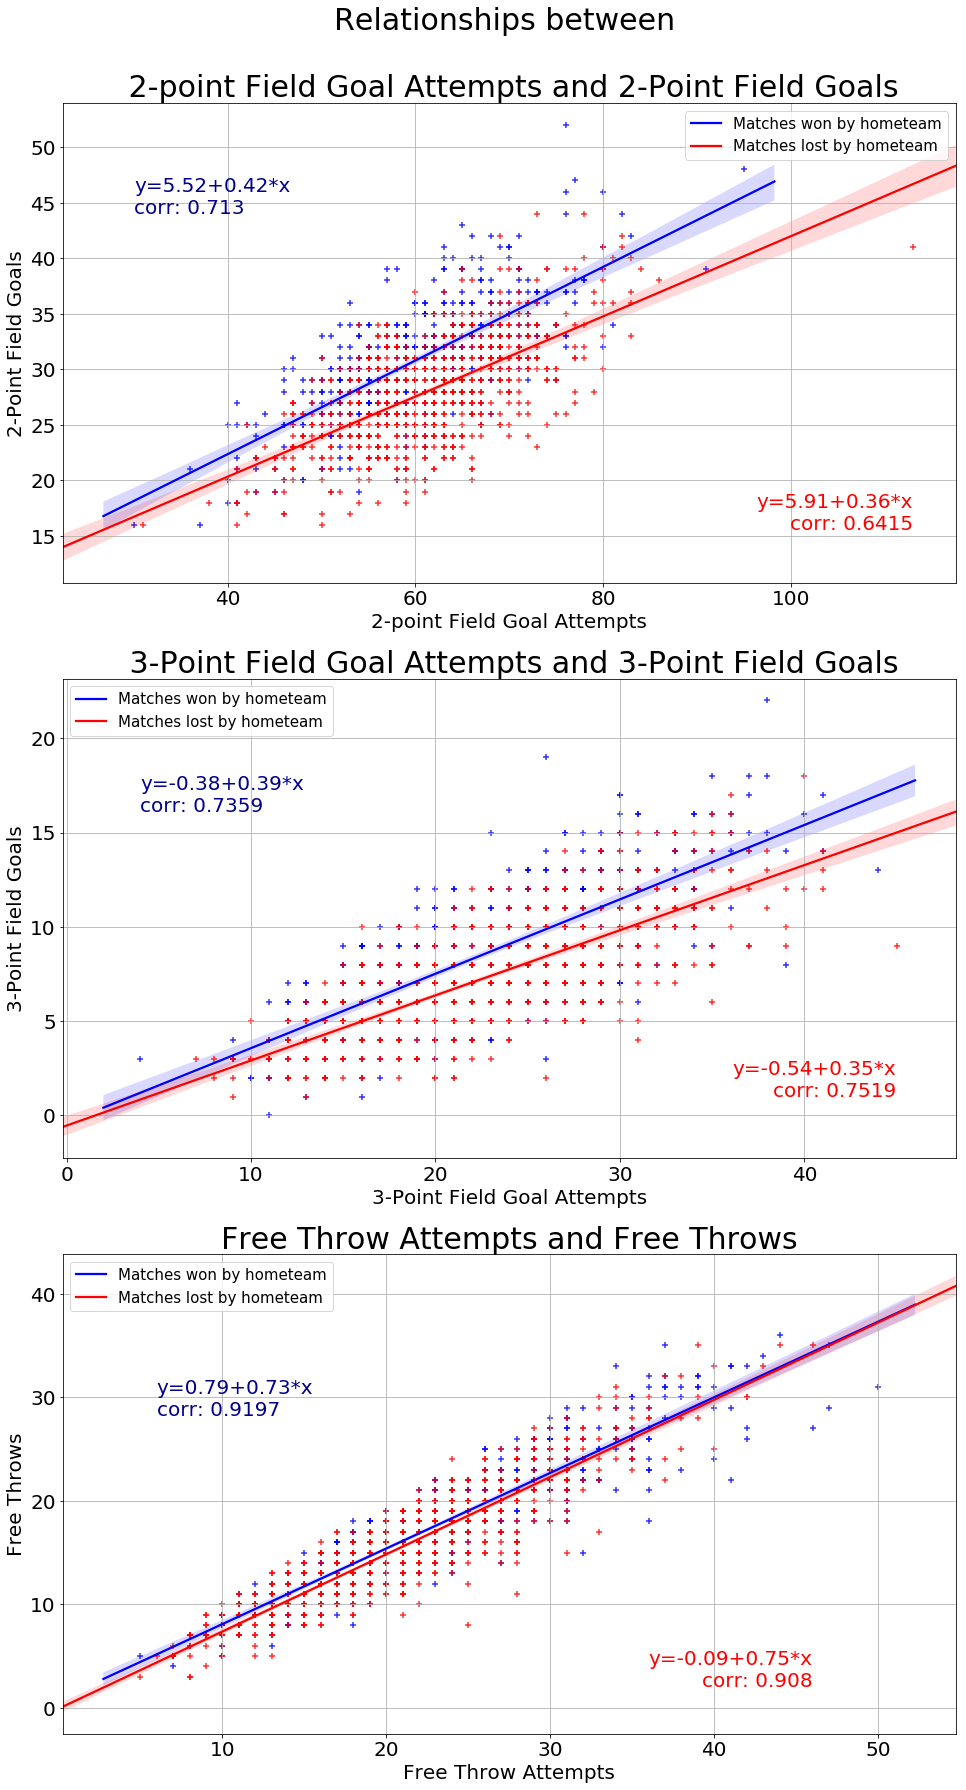

In [10]:
fig = plt.figure(figsize=(16,30))
eq_fontsize = 20
label_fontsize = 20
legend_size = 15
title_fs = 30

ax1 = plt.subplot(3, 1, 1)
x,y = '2-point Field Goal Attempts', '2-Point Field Goals'

won_fit = np.polyfit(df_2015[df_2015['Result']==1][x],df_2015[df_2015['Result']==1][y],1)
lost_fit = np.polyfit(df_2015[df_2015['Result']==0][x],df_2015[df_2015['Result']==0][y],1)
corr_win = pearsonr(df_2015[df_2015['Result']==1][x],df_2015[df_2015['Result']==1][y])
corr_lost = pearsonr(df_2015[df_2015['Result']==0][x],df_2015[df_2015['Result']==0][y])


sns.regplot(x=df_2015[df_2015['Result']==1][x],y=df_2015[df_2015['Result']==1][y],color='blue', marker='+')
sns.regplot(x = df_2015[df_2015['Result']==0][x],y=df_2015[df_2015['Result']==0][y], color = 'red', marker='+')
# Regression lines.

tp_xw = min(df_2015[df_2015['Result']==1][x])
tp_yw = max(won_fit[0]*df_2015[df_2015['Result']==1][x]+won_fit[1])
tp_xl = max(df_2015[df_2015['Result']==0][x])
tp_yl = min(lost_fit[0]*df_2015[df_2015['Result']==0][x]+lost_fit[1])


# Regression equations.
plt.text(tp_xw,tp_yw,'y={:.2f}+{:.2f}*x\ncorr: {:.4}'.format(won_fit[1],won_fit[0], corr_win[0]),color='darkblue',size=eq_fontsize, horizontalalignment='left',verticalalignment='center')
plt.text(tp_xl,tp_yl,'y={:.2f}+{:.2f}*x\ncorr: {:.4}'.format(lost_fit[1],lost_fit[0], corr_lost[0]),color='red',size=eq_fontsize, horizontalalignment='right',verticalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize)

plt.legend(labels=['Matches won by hometeam','Matches lost by hometeam'], loc='best', prop={'size': legend_size})
plt.title(f'Relationships between \n\n {x} and {y}', size=title_fs)
plt.grid()
plt.xlabel(f'{x}', size=label_fontsize)
plt.ylabel(f'{y}', size=label_fontsize);



ax2 = plt.subplot(3, 1, 2)
x,y = '3-Point Field Goal Attempts', '3-Point Field Goals'

won_fit = np.polyfit(df_2015[df_2015['Result']==1][x],df_2015[df_2015['Result']==1][y],1)
lost_fit = np.polyfit(df_2015[df_2015['Result']==0][x],df_2015[df_2015['Result']==0][y],1)
corr_win = pearsonr(df_2015[df_2015['Result']==1][x],df_2015[df_2015['Result']==1][y])
corr_lost = pearsonr(df_2015[df_2015['Result']==0][x],df_2015[df_2015['Result']==0][y])



sns.regplot(x=df_2015[df_2015['Result']==1][x],y=df_2015[df_2015['Result']==1][y],color='blue', marker='+')
sns.regplot(x = df_2015[df_2015['Result']==0][x],y=df_2015[df_2015['Result']==0][y], color = 'red', marker='+')
# Regression lines.

tp_xw = min(df_2015[df_2015['Result']==1][x])
tp_yw = max(won_fit[0]*df_2015[df_2015['Result']==1][x]+won_fit[1])
tp_xl = max(df_2015[df_2015['Result']==0][x])
tp_yl = min(lost_fit[0]*df_2015[df_2015['Result']==0][x]+lost_fit[1])


# Regression equations.
plt.text(tp_xw,tp_yw,'y={:.2f}+{:.2f}*x\ncorr: {:.4}'.format(won_fit[1],won_fit[0], corr_win[0]),color='darkblue',size=eq_fontsize, horizontalalignment='left',verticalalignment='center')
plt.text(tp_xl,tp_yl,'y={:.2f}+{:.2f}*x\ncorr: {:.4}'.format(lost_fit[1],lost_fit[0], corr_lost[0]),color='red',size=eq_fontsize, horizontalalignment='right',verticalalignment='center')
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)

plt.legend(labels=['Matches won by hometeam','Matches lost by hometeam'], loc='best', prop={'size': legend_size})
plt.title(f' {x} and {y}', size=title_fs)
plt.grid()
plt.xlabel(f'{x}', size=label_fontsize)
plt.ylabel(f'{y}', size=label_fontsize);



ax3 = plt.subplot(3, 1, 3)
x,y = 'Free Throw Attempts', 'Free Throws'

won_fit = np.polyfit(df_2015[df_2015['Result']==1][x],df_2015[df_2015['Result']==1][y],1)
lost_fit = np.polyfit(df_2015[df_2015['Result']==0][x],df_2015[df_2015['Result']==0][y],1)
corr_win = pearsonr(df_2015[df_2015['Result']==1][x],df_2015[df_2015['Result']==1][y])
corr_lost = pearsonr(df_2015[df_2015['Result']==0][x],df_2015[df_2015['Result']==0][y])



sns.regplot(x=df_2015[df_2015['Result']==1][x],y=df_2015[df_2015['Result']==1][y],color='blue', marker='+')
sns.regplot(x = df_2015[df_2015['Result']==0][x],y=df_2015[df_2015['Result']==0][y], color = 'red', marker='+')
# Regression lines.

tp_xw = min(df_2015[df_2015['Result']==1][x])
tp_yw = max(won_fit[0]*df_2015[df_2015['Result']==1][x]+won_fit[1])
tp_xl = max(df_2015[df_2015['Result']==0][x])
tp_yl = min(lost_fit[0]*df_2015[df_2015['Result']==0][x]+lost_fit[1])


# Regression equations.
plt.text(tp_xw*1.2,tp_yw*0.8,'y={:.2f}+{:.2f}*x\ncorr: {:.4}'.format(won_fit[1],won_fit[0], corr_win[0]),color='darkblue',size=eq_fontsize, horizontalalignment='left',verticalalignment='center')
plt.text(tp_xl,tp_yl,'y={:.2f}+{:.2f}*x\ncorr: {:.4}'.format(lost_fit[1],lost_fit[0], corr_lost[0]),color='red',size=eq_fontsize, horizontalalignment='right',verticalalignment='center')
ax3.tick_params(axis='both', which='major', labelsize=label_fontsize)

plt.legend(labels=['Matches won by hometeam','Matches lost by hometeam'], loc='best', prop={'size': legend_size})
plt.title(f'{x} and {y}', size=title_fs)
plt.grid()
plt.xlabel(f'{x}', size=label_fontsize)
plt.ylabel(f'{y}', size=label_fontsize);





Interesting to see that all these three figures confirm that the fans do influence the outcome of a match.

For both the 2-point and 3-point attempts there is a significant increase in the success of the attempts (slope of the line). The correlation varies, which tells us that the outcome of the attempts are not so predictable. 

For those matches where the home team won, we can assume that they attempted more (and succeded more frequently) so that they balanced the opponents' tries. However, when the visiting team won, the slope is less steep, which -- based on the same narrative -- suggests that the fans or the surroundings of the place might have an influence on the concentration of the players during the matches.

To prove my point again, take a look at the third picture. Free throws are fixed situations, where one player can take a deep breath and concentrate. In this case, professional players must be able to block the annoying circumstances, which explains why the correlation is so high -- the outcome of the attempt is very predictable. Furthermore, there is no real difference in the steepness of the slope, so that my point can be prove again, that with concentration one can succeed more often. 

# 3) SVM and prediction

In [11]:
clf = svm.SVC(kernel='linear')
clf.fit(df_2015.drop("Result", axis = 1), df_2015.Result) 
print(clf.predict(df_2016.drop("Result", axis = 1)))

[0. 0. 0. ... 1. 1. 0.]


In [12]:
clf = svm.SVC(kernel='rbf')
clf.fit(df_2015.drop("Result", axis = 1), df_2015.Result) 
print(clf.predict(df_2016.drop("Result", axis = 1)))


[0. 0. 0. ... 0. 0. 0.]


In [13]:
"""
clf = svm.SVC(kernel='poly')
clf.fit(df_2015.drop("Result", axis = 1), df_2015.Result) 
print(clf.predict(df_2016.drop("Result", axis = 1)))
"""

'\nclf = svm.SVC(kernel=\'poly\')\nclf.fit(df_2015.drop("Result", axis = 1), df_2015.Result) \nprint(clf.predict(df_2016.drop("Result", axis = 1)))\n'

'poly' is very expensive. Lets manipulate the data

In [14]:
df_2015n = (df_2015-df_2015.mean())/df_2015.std()
df_2016n = (df_2016-df_2016.mean())/df_2016.std()

In [15]:
df_2015n["Result"] = df_2015n.Result.apply(lambda x: 0 if x<=0 else 1)
df_2016n["Result"] = df_2016n.Result.apply(lambda x: 0 if x<=0 else 1)

In [16]:
clfl = svm.SVC(kernel='linear')
clfl.fit(df_2015n.drop("Result", axis = 1), df_2015n.Result) 
clfl_p = clfl.score(df_2016n.drop("Result", axis = 1), df_2016n.Result)

clfp = svm.SVC(kernel='poly')
clfp.fit(df_2015n.drop("Result", axis = 1), df_2015n.Result) 
clfp_p = clfp.score(df_2016n.drop("Result", axis = 1), df_2016n.Result)


clfr = svm.SVC(kernel='rbf')
clfr.fit(df_2015n.drop("Result", axis = 1), df_2015n.Result) 
clfr_p = clfr.score(df_2016n.drop("Result", axis = 1), df_2016n.Result)

In [17]:
print(clfl_p,  clfp_p, clfr_p)

0.7137129109863672 0.6607858861267041 0.7129109863672815


In [18]:
C = np.logspace(-6, 3, 25, endpoint=True)
scores = []
for c in C:
    clf = svm.SVC(kernel='linear', C=c)
    clf.fit(df_2015n.drop("Result", axis = 1), df_2015n.Result) 
    scores.append(clf.score(df_2016n.drop("Result", axis = 1), df_2016n.Result))

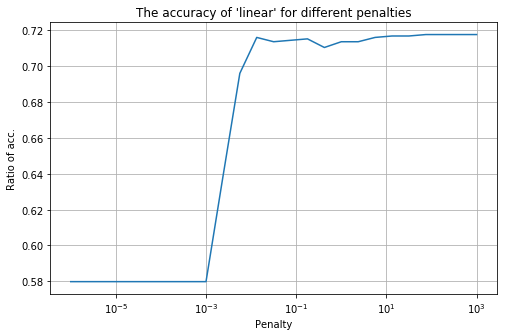

In [19]:
plt.figure(figsize=(8,5))

plt.semilogx(C, scores, label = "Accuracy")
plt.xlabel("Penalty")
plt.ylabel("Ratio of acc.")
plt.grid()
plt.title("The accuracy of \'linear\' for different penalties");

# 4) Prediction of 2016 matches

In [20]:
clfe = svm.SVC(kernel='rbf', C = 0.75, probability=True)
clfe.fit(df_2015[['Free Throws', '3-Point Field Goals']], df_2015.Result) 
clfe6 = clfe.predict_proba(df_2016[['Free Throws', '3-Point Field Goals']])
clfe5 = clfe.predict_proba(df_2015[['Free Throws', '3-Point Field Goals']])

In [21]:
roc5 = roc_curve(df_2015.Result, clfe5[:, 1])
roc6 = roc_curve(df_2016.Result, clfe6[:,1])

Text(0.5, 0, 'Specificity')

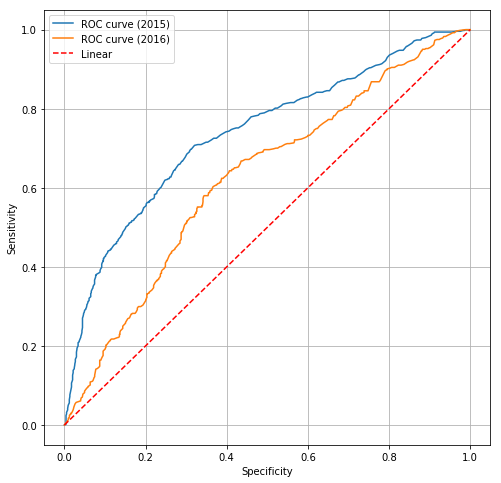

In [22]:
plt.figure(figsize=(8,8))
plt.plot(roc5[0], roc5[1], label = 'ROC curve (2015)')
plt.plot(roc6[0], roc6[1], label = 'ROC curve (2016)')
plt.plot([0,1],[0,1], "r--" , label = 'Linear')
plt.grid()
plt.legend(loc = "best")
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')

In [23]:
res = 100
x = np.linspace(df_2016["Free Throws"].min(), df_2016["Free Throws"].max(), res)
y = np.linspace(df_2016["3-Point Field Goals"].min(), df_2016["3-Point Field Goals"].max(), res)
z = np.zeros_like(np.outer(x,y))

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        z[i,j] = clfe.predict_proba(np.array([[x[i], y[j]]]))[0][0]

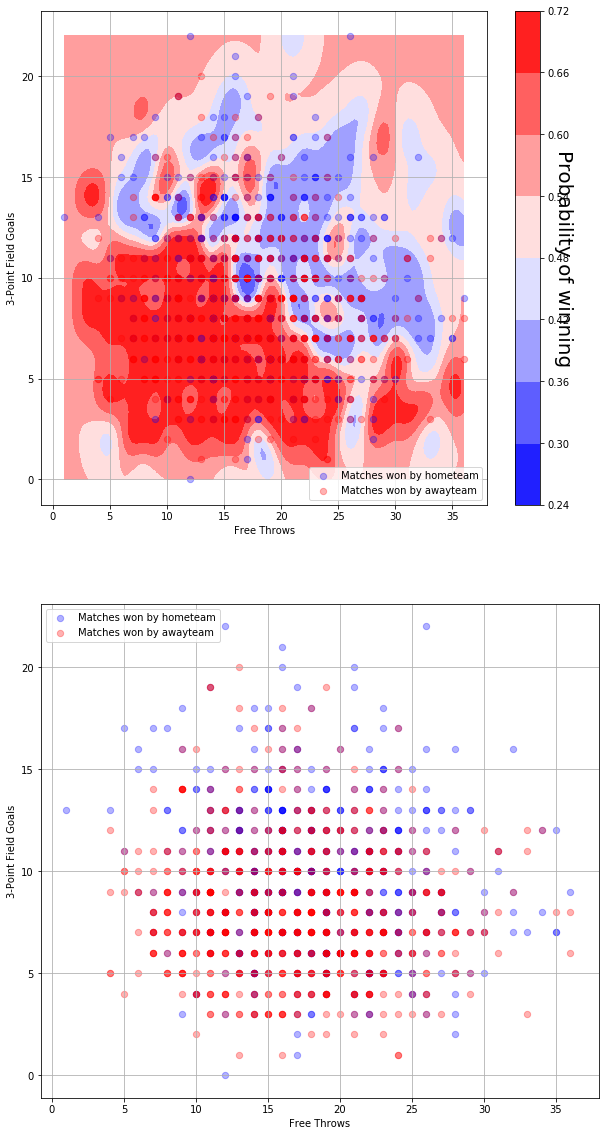

In [24]:
fig = plt.figure(figsize=(10,20))
eq_fontsize = 40
alpha = .3


axe = plt.subplot(2, 1, 1)
r = axe.contourf(x,y,z.T, cmap = "bwr")
cbar = plt.colorbar(r, ax=axe, cmap = "bwr")
cbar.set_label('Probability of winning',fontsize = 20, rotation=270)

x_lab, y_lab = "Free Throws", "3-Point Field Goals"
df_2016[df_2016['Result']==1].plot(kind='scatter', x=x_lab,y=y_lab, color='blue', s = eq_fontsize, alpha=alpha,ax = axe, label = "Matches won by hometeam")
df_2016[df_2016['Result']==0].plot(kind='scatter', x=x_lab,y=y_lab, color='red', s = eq_fontsize, alpha=alpha, ax=axe, label = "Matches won by awayteam")
axe.grid()
axe.legend(loc = "best")

axe2 = plt.subplot(2, 1, 2)


df_2016[df_2016['Result']==1].plot(kind='scatter', x=x_lab,y=y_lab, color='blue', s = eq_fontsize, alpha=alpha,ax = axe2, label = "Matches won by hometeam")
df_2016[df_2016['Result']==0].plot(kind='scatter', x=x_lab,y=y_lab, color='red', s = eq_fontsize, alpha=alpha, ax=axe2, label = "Matches won by awayteam")
axe2.grid()

axe2.legend(loc = "best");